In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
titanic_data = pd.read_csv('data/train.csv')

#### Correlation
We had a problem with ValueError caused by trying to convert string values to floats during the correlation calculation. To fix this: use numeric_only=True to ensure corr() function ignores non-numeric columns. 
In the heatmap, yellow means negatively correlated which makes sense. Eg: Higher survival → lower Pclass meaning higher SES (low Pclass) had a higher rate of survival

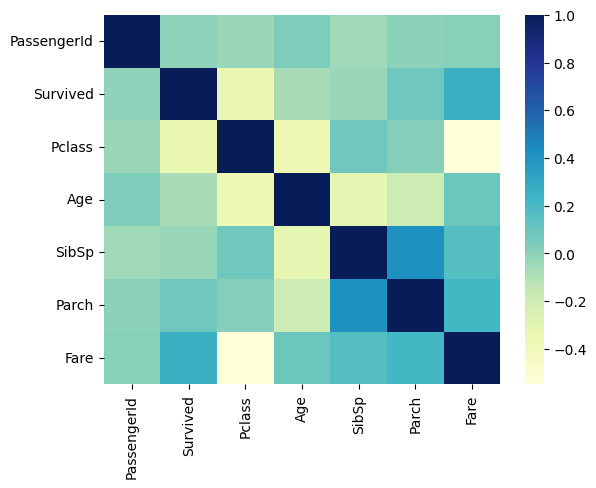

In [3]:
import seaborn as sns
sns.heatmap(titanic_data.corr(numeric_only=True), cmap="YlGnBu")
plt.show()

First, we want to create train/test splits while preserving the percentage of samples for each class. 
n_splits=1 means that only one train/test split will be created. test_size = 0.2 means that 20% of the data will be used for the test set. split.split method takes two arguments:
    titanic_data - the full dataset that needs to be split 
    titanic_data[["Survived", "Pclass", "Sex"]] - this will try to preserve the distribution of these columns in the train and test sets
.loc explicitly tells pandas that you are selecting rows based on indices provided


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

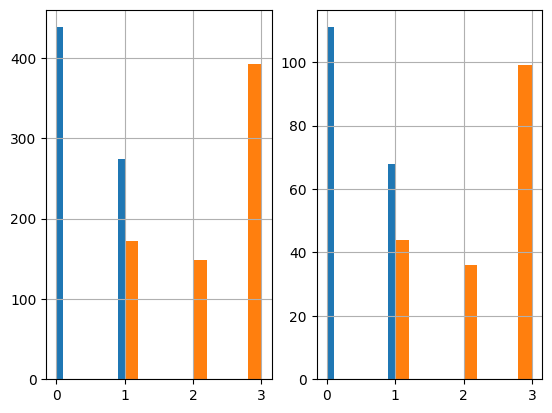

In [5]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [6]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 576 to 332
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          569 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


#### Estimators
BaseEstimator and TransformerMixin help create custom transformers (custom transformers implement fit and transform methods by inheriting properties from the above two classes).
SimpleImputer (a built-in transformer) is used to fill in missing values in the dataset

class AgeImputer: Defines a new class named AgeImputer 
(BaseEstimator, TransformerMixin) means AgeImputer inherits properties and methods from both classes

self is a reference to the current instance of the class. Include self as the first parameter to indicate that these methods are associated with an instance of the class.

Purpose of fitting: learn necessary parameters from training data (compute statistics/other necessary info like mean)
Purpose of transforming: Modify the data from what is learnt during fitting

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

#### Encoding

The purpose of this class is to transform categorical features like 'Embarked' and 'Sex' into a format that can be used in machine learning models, specifically using one-hot encoding. 
We do the same as above with BaseEstimator, TransformerMixin, making it compatible with scikit-learn pipelines.
len(matrix.T) gives the number of categories (rows in the transposed matrix). 
We do all this to simplify the process of assigning each category's binary values to new columns in the DataFrame.

In [8]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        encoder = OneHotEncoder()

        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["C", "S", "Q", "N"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i] # Adds each transposed row as a new column in the DataFrame with the appropriate name. 

        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

#### Feature Dropper

This is where we drop some columns that are/no longer relevant anymore. Since we have already encoded "Embarked" and "Sex", we can proceed to drop them as well. Columns such as "Name" are unlikely to help us with predicting so we can drop them as well. 

In [9]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

#### Pipeline
Pipeline is a way to organise a series of data processing steps into a single project. 

In [10]:
from sklearn.pipeline import Pipeline
# We can crete a Pipeline object and store it in the variable pipeline. The Pipeline object will be used to apply multiple steps to the data in a sequence. 
pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [11]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [12]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 576 to 332
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [13]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis = 1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [15]:
final_clf = grid_search.best_estimator_

In [16]:
final_clf

RandomForestClassifier(min_samples_split=4, n_estimators=200)

In [17]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [18]:
X_test = strat_test_set.drop(['Survived'], axis = 1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [19]:
final_clf.score(X_data_test, y_data_test)

0.8268156424581006

In [20]:
final_data = pipeline.fit_transform(titanic_data)

In [21]:
X_final = final_data.drop(['Survived'], axis =1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [22]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [23]:
prod_final_clf = grid_search.best_estimator_

In [24]:
titanic_test_data = pd.read_csv("data/test.csv")

In [25]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [26]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [27]:
X_final_test = final_test_data
X_final_test = X_final_test.ffill()

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [28]:
predictions = prod_final_clf.predict(X_data_final_test)

In [29]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("data/predictions.csv", index=False)

In [30]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
